In [63]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import scipy.signal as sig
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [64]:
labels = pd.read_csv('data_labels\CIS-PD_Training_Data_IDs_Labels.csv')
labels.subject_id = labels.subject_id.astype(str)

labels[["on_off", "tremor", "dyskinesia"]].corr()


,on_off,tremor,dyskinesia
on_off,1.00000,0.390800,0.352530
tremor,0.39080,1.000000,0.562339
dyskinesia,0.35253,0.562339,1.000000


In [65]:
null = pd.read_csv('null_solution.csv')
tremor_preds=null[["subject_id", "tremor"]]
tremor_preds=tremor_preds.rename(columns={"tremor":"tremor_null"})
labels=pd.merge(labels, tremor_preds, how="left", on=["subject_id"])


1.0    633
0.0    513
2.0    205
3.0    102
4.0      9
Name: tremor, dtype: int64


Text(0.5, 1.0, 'tremor')

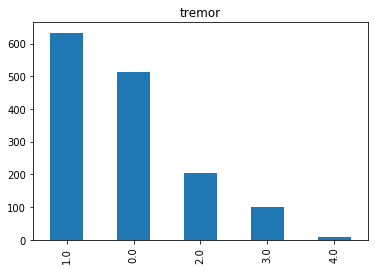

In [66]:
print(labels['tremor'].value_counts())
labels['tremor'].value_counts().plot(kind='bar')
plt.title('tremor')


In [67]:
pd.pivot_table(labels[["subject_id","tremor"]], index="subject_id", columns=["tremor"],aggfunc=len)

tremor,0.0,1.0,2.0,3.0,4.0
subject_id,,,,,
1004,41.0,16.0,10.0,14.0,1.0
1006,12.0,18.0,7.0,NaN,NaN
1007,210.0,80.0,9.0,NaN,NaN
1019,7.0,24.0,14.0,NaN,NaN
1020,15.0,156.0,24.0,NaN,NaN
1023,74.0,28.0,3.0,1.0,NaN
1032,105.0,70.0,2.0,NaN,NaN
1034,20.0,19.0,1.0,NaN,NaN
1038,1.0,134.0,71.0,1.0,NaN


In [68]:
"""define frequency bands the step function"""
W_n = [3,7];

"""Select the step function"""
Ord = sig.buttord(wp = [4,6],ws =[3,7],gpass =0.08, gstop = 10,fs = 50)
Filter = sig.butter(Ord[0],Wn = W_n,btype = 'bandpass',fs =50);

Text(0.5, 0, 'Frequency[Hz]')

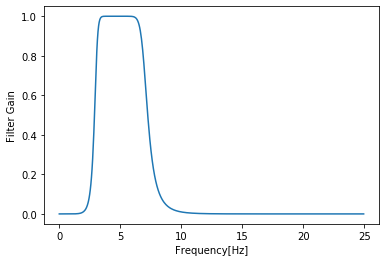

In [69]:
"""Plot the frequency response"""
Response = sig.freqz(Filter[0],Filter[1],fs=50)

plt.plot(Response[0],np.abs(Response[1]))
plt.ylabel("Filter Gain");
plt.xlabel("Frequency[Hz]")

In [70]:
#pd.read_csv(f) for f in all_filenames 

mycsvdir = 'training_data\CIS_training'

csvfiles = glob.glob(os.path.join(mycsvdir, '*.csv'))

Means=[]


for csvfile in csvfiles:
    pre_df = pd.read_csv(csvfile)
    
    numsamples,numfeatures = pre_df.shape
    windowsize=numsamples//40
    start=0
    end=windowsize
    
    for i in range(0,40):
        df = pre_df.iloc[start:end]
        start+=windowsize
        end+=windowsize
    
   
        """Apply Hypothesis tests to check if means are statistically significant????"""
        #Relevant features 
        measurement_id = os.path.basename(csvfile)
        measurement_id = measurement_id.replace(".csv","")

        df["r"] = np.sqrt(df.X**2+df.Y**2+df.Z**2)
        dr = np.sqrt(np.diff(df.X)**2+np.diff(df.Y)**2+np.diff(df.Z)**2)
        
        mean_r = np.median(df.r)
        std_r = np.std(df.r)
        min_r = np.min(df.r)
        max_r = np.max(df.r)
        skew_r = skew(df.r)
        kurtosis_r = kurtosis(df.r)

        mean_dr = np.median(dr)
        std_dr = np.std(dr)
        min_dr = np.min(dr)
        max_dr = np.max(dr)
        skew_dr = skew(dr)
        kurtosis_dr = kurtosis(dr)

        """Extract frequency bands in Hz"""
        FreqBandx = sig.lfilter(Filter[0],Filter[1],df["X"]);
        FreqBandy = sig.lfilter(Filter[0],Filter[1],df["Y"]);
        FreqBandz = sig.lfilter(Filter[0],Filter[1],df["Z"]);

        """Find the power in each frequency Band"""
        PowerFreqBandx = np.abs(FreqBandx)**2;
        PowerFreqBandy = np.abs(FreqBandy)**2;
        PowerFreqBandz = np.abs(FreqBandz)**2;

        """Sum the power in each frequency band"""
        SumPowerFreqBandx = np.sum(PowerFreqBandx);
        SumPowerFreqBandy = np.sum(PowerFreqBandy);
        SumPowerFreqBandz = np.sum(PowerFreqBandz);

        """Sum the total signal power"""
        Powerx = np.sum(df["X"]**2);
        Powery = np.sum(df["Y"]**2);
        Powerz = np.sum(df["Z"]**2);

        """Find the percentage of power in frequencies of interest"""
        FreqPower = np.sqrt((SumPowerFreqBandx+SumPowerFreqBandy+SumPowerFreqBandz)/(Powerx+Powery+Powerz));

        Means.append([measurement_id, mean_r, std_r, min_r, max_r, skew_r, kurtosis_r, 
                         mean_dr,std_dr, min_dr, max_dr, skew_dr, kurtosis_dr,FreqPower])

C:\Users\lisbe\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [71]:
accel_phones= pd.DataFrame(Means, columns=["measurement_id", "mean_r", "std_r", 
                                              "min_r", "max_r", "skew_r", "kurtosis_r",
                                              "mean_dr", "std_dr", "min_dr", "max_dr", 
                                              "skew_dr", "kurtosis_dr","FreqPower"])
   



In [72]:
accel_phones.shape

(74320, 14)

In [73]:
data=pd.merge(accel_phones, labels, on="measurement_id")
data.shape

(74320, 19)

In [74]:
data.head()

,measurement_id,mean_r,std_r,min_r,max_r,skew_r,kurtosis_r,mean_dr,std_dr,min_dr,max_dr,skew_dr,kurtosis_dr,FreqPower,subject_id,on_off,dyskinesia,tremor,tremor_null
0,004ed441-24db-4839-8b5d-7465e4ea2a0a,0.994532,0.005499,0.971644,1.149643,20.771172,540.638126,0.003025,0.028240,0.000000,0.771119,20.549539,471.579338,0.023151,1038,4.0,0.0,2.0,1.347826
1,004ed441-24db-4839-8b5d-7465e4ea2a0a,0.994616,0.001539,0.989342,0.999837,0.093288,0.287893,0.002950,0.001318,0.000000,0.008823,0.598514,0.398853,0.018428,1038,4.0,0.0,2.0,1.347826
2,004ed441-24db-4839-8b5d-7465e4ea2a0a,0.994496,0.001605,0.988774,0.999971,0.122465,0.147495,0.002980,0.001371,0.000000,0.008347,0.672518,0.469124,0.018399,1038,4.0,0.0,2.0,1.347826
3,004ed441-24db-4839-8b5d-7465e4ea2a0a,0.994548,0.001845,0.987834,1.021617,2.238766,31.343783,0.003010,0.001876,0.000000,0.032259,5.579316,72.927067,0.018404,1038,4.0,0.0,2.0,1.347826
4,004ed441-24db-4839-8b5d-7465e4ea2a0a,0.994377,0.001590,0.988919,1.000757,0.049215,0.356977,0.002980,0.001330,0.000488,0.010811,0.746977,1.178548,0.018416,1038,4.0,0.0,2.0,1.347826


In [75]:
df_tremors=data.drop(['on_off', 'dyskinesia'], axis=1)
df_tremors=df_tremors.dropna()

In [76]:
df_tremors[df_tremors["measurement_id"]== '004ed441-24db-4839-8b5d-7465e4ea2a0a']

,measurement_id,mean_r,std_r,min_r,max_r,skew_r,kurtosis_r,mean_dr,std_dr,min_dr,max_dr,skew_dr,kurtosis_dr,FreqPower,subject_id,tremor,tremor_null
0,004ed441-24db-4839-8b5d-7465e4ea2a0a,0.994532,0.005499,0.971644,1.149643,20.771172,540.638126,0.003025,0.028240,0.000000,0.771119,20.549539,471.579338,0.023151,1038,2.0,1.347826
1,004ed441-24db-4839-8b5d-7465e4ea2a0a,0.994616,0.001539,0.989342,0.999837,0.093288,0.287893,0.002950,0.001318,0.000000,0.008823,0.598514,0.398853,0.018428,1038,2.0,1.347826
2,004ed441-24db-4839-8b5d-7465e4ea2a0a,0.994496,0.001605,0.988774,0.999971,0.122465,0.147495,0.002980,0.001371,0.000000,0.008347,0.672518,0.469124,0.018399,1038,2.0,1.347826
3,004ed441-24db-4839-8b5d-7465e4ea2a0a,0.994548,0.001845,0.987834,1.021617,2.238766,31.343783,0.003010,0.001876,0.000000,0.032259,5.579316,72.927067,0.018404,1038,2.0,1.347826
4,004ed441-24db-4839-8b5d-7465e4ea2a0a,0.994377,0.001590,0.988919,1.000757,0.049215,0.356977,0.002980,0.001330,0.000488,0.010811,0.746977,1.178548,0.018416,1038,2.0,1.347826
5,004ed441-24db-4839-8b5d-7465e4ea2a0a,0.994436,0.001560,0.988421,1.000024,0.118566,0.166719,0.002960,0.001353,0.000000,0.008174,0.539617,0.147029,0.018425,1038,2.0,1.347826
6,004ed441-24db-4839-8b5d-7465e4ea2a0a,0.994436,0.001934,0.979159,1.005701,0.132059,5.065772,0.003127,0.001863,0.000488,0.034262,4.620840,58.451358,0.018405,1038,2.0,1.347826
7,004ed441-24db-4839-8b5d-7465e4ea2a0a,0.994466,0.002081,0.971415,1.007754,-0.766045,16.807815,0.003020,0.002006,0.000000,0.028435,4.019877,33.996861,0.018395,1038,2.0,1.347826
8,004ed441-24db-4839-8b5d-7465e4ea2a0a,0.994498,0.001844,0.988992,1.000622,0.124989,-0.141493,0.003325,0.001496,0.000000,0.008809,0.402435,-0.218062,0.018399,1038,2.0,1.347826
9,004ed441-24db-4839-8b5d-7465e4ea2a0a,0.994366,0.001882,0.988785,1.000437,0.006228,0.050725,0.003356,0.001551,0.000488,0.009500,0.661410,0.380057,0.018411,1038,2.0,1.347826


In [77]:
train, test = train_test_split(df_tremors, test_size=0.2, random_state=42, stratify=df_tremors['subject_id'])

print(train.shape)
print(test.shape)


(46784, 17)
(11696, 17)


In [78]:
train.head()

,measurement_id,mean_r,std_r,min_r,max_r,skew_r,kurtosis_r,mean_dr,std_dr,min_dr,max_dr,skew_dr,kurtosis_dr,FreqPower,subject_id,tremor,tremor_null
51006,aefa798a-793d-48ba-8437-e0394bb6b961,1.060854,0.317646,0.172926,3.007755,1.592442,6.296905,0.229215,0.200783,0.011370,1.564367,1.909446,5.137905,0.199139,1049,2.0,1.817073
28320,5fb42d13-698b-4c7d-adf6-6a73007ae012,0.989625,0.045633,0.717013,1.426849,1.643087,24.114875,0.006818,0.040685,0.000691,0.419809,3.624352,17.572172,0.042450,1007,0.0,0.327759
61298,d1d73f69-6b27-4a0c-a530-05b74907eebb,0.996026,0.056306,0.791098,1.305806,0.855270,4.491830,0.024109,0.038390,0.000691,0.241538,2.037945,4.849029,0.055887,1032,0.0,0.418079
65637,e28a0cf0-12a3-4f76-b900-dbf397a10787,0.993641,0.019897,0.939265,1.079733,0.540442,0.360168,0.015395,0.011449,0.001196,0.082088,1.418797,3.216222,0.030530,1046,0.0,0.850746
16640,38392387-d09a-40a4-afa7-9f3654066f28,0.990957,0.164113,0.425685,2.092106,1.199620,4.097542,0.054350,0.108281,0.000000,1.218460,3.808993,23.016604,0.112039,1007,0.0,0.327759


In [79]:
cols_to_transform=train.columns[1:-3]
scaler= StandardScaler()
#scaler=MinMaxScaler()
scaler= scaler.fit(train[cols_to_transform])
train[cols_to_transform] = scaler.transform(train[cols_to_transform])
test[cols_to_transform] = scaler.transform(test[cols_to_transform])


C:\Users\lisbe\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\lisbe\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\lisbe\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [80]:
X_train = train.drop(['tremor', 'tremor_null', 'measurement_id'], axis=1)
y_train = train.tremor
null_train = train.tremor_null
X_test=test.drop(['tremor', 'tremor_null', 'measurement_id'], axis=1)
y_test = test.tremor
null_test = test.tremor_null

In [81]:
X_train_dummies = pd.get_dummies(X_train)
X_test_dummies= pd.get_dummies(X_test)


In [131]:
print(X_train_dummies.shape)
print(X_test_dummies.shape)
print(y_train.shape)
print(y_test.shape)

(46784, 26)
(11696, 26)
(46784,)
(11696,)


In [132]:
import xgboost as xgb

dtrain=xgb.DMatrix(data=X_train_dummies, label=y_train)
dtest = xgb.DMatrix(data=X_test_dummies)

C:\Users\lisbe\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\lisbe\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [133]:
param = {'objective': 'reg:squarederror',
         'max_depth' : 5,
         'learning_rate': 0.4
        }
bst = xgb.train(param, dtrain)
xgb_pred = bst.predict(dtest)

In [134]:
test['xgb_pred']=xgb_pred
test.head()

C:\Users\lisbe\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,measurement_id,mean_r,std_r,min_r,max_r,skew_r,kurtosis_r,mean_dr,std_dr,min_dr,max_dr,skew_dr,kurtosis_dr,FreqPower,subject_id,tremor,tremor_null,xgb_pred
9262,2115c1d0-852f-46b2-a250-9ad4d0ff0943,-0.297916,-0.833184,1.375028,-0.604965,-0.434895,-0.357278,-0.808060,-0.768348,-0.566694,-0.622964,-0.787225,-0.556286,-0.812722,1020,1.0,1.046154,1.072807
52544,b54b0611-9a0b-4d10-9658-0dd7023074f1,0.230738,-0.442807,-0.268465,-0.220218,-0.320726,0.054428,-0.594362,-0.199080,-0.566694,-0.004463,0.758690,0.526271,-0.541376,1020,1.0,1.046154,1.061293
9478,21928f3e-de68-4808-acde-3e3eacbc0de0,-0.051256,-0.756399,1.343416,-0.585321,-0.447097,-0.422436,-0.392637,-0.692459,1.534092,-0.597393,-1.152350,-0.619730,-0.464830,1048,2.0,2.824176,2.475641
69449,eef56825-940a-4c3e-aebb-60838d60869e,-0.122186,0.227294,0.425238,-0.385188,-0.484850,-0.437092,1.189158,-0.098431,0.503220,-0.371087,-1.005178,-0.604999,0.969932,1048,4.0,2.824176,3.298662
62523,d7bb16f5-2872-4743-9563-254fcce3c3dc,-0.650830,-0.386797,-0.061255,-0.044356,0.694523,0.468656,-0.432712,-0.232714,0.200491,-0.040843,0.552460,0.340219,-0.263773,1038,1.0,1.347826,1.307398


In [135]:
results=pd.DataFrame(test.groupby('measurement_id', as_index=False).agg({'xgb_pred':[np.mean], 'tremor':pd.Series.mode, 'tremor_null':pd.Series.mode}))

In [136]:
results

,measurement_id,xgb_pred,tremor,tremor_null
,,mean,mode,mode
0,004ed441-24db-4839-8b5d-7465e4ea2a0a,1.361232,2.0,1.347826
1,00544f67-c07c-4a07-9c17-a7aee51d8b96,1.764482,2.0,1.817073
2,00bbb4c4-bb9a-4c3a-9c1b-3bf5f079d336,0.916158,1.0,0.864865
3,00c6a1c3-178d-4f21-ba88-512c4a734541,0.413693,0.0,0.418079
4,0135a045-7978-4e4a-af98-38e645710934,1.007610,1.0,1.046154
...,...,...,...,...
1457,ff404d2a-3896-4a6a-ae75-4b9d3c86cae3,0.366536,1.0,0.327759
1458,ff4bb4df-b798-4ff1-947c-0131b5c925b6,0.313701,1.0,0.349057
1459,ff5e4e8f-dace-4913-9ea9-e7f4f80a9233,0.340398,1.0,0.327759


In [137]:
metrics.mean_squared_error(results['tremor'], results['xgb_pred'])

0.35296840125188583

In [138]:
metrics.mean_squared_error(results['tremor'], results['tremor_null'])

0.3894297156413139

In [139]:
stats=test.groupby('tremor', as_index=False).agg({'xgb_pred':[np.mean,np.std]})
stats

tremor  xgb_pred          
              mean       std
0    0.0  0.487245  0.263290
1    1.0  0.915090  0.400949
2    2.0  1.400522  0.603992
3    3.0  2.266171  0.686305
4    4.0  2.686443  0.508211

In [140]:
stats.columns[1]

('xgb_pred', 'mean')

In [141]:
stats['tremor']

0    0.0
1    1.0
2    2.0
3    3.0
4    4.0
Name: tremor, dtype: float64

In [142]:
results['preds']=round(results['xgb_pred'])

In [143]:
metrics.accuracy_score(results['tremor'], results['preds'])

0.6313269493844049

In [144]:
print(metrics.classification_report(results['tremor'], results['preds']))

              precision    recall  f1-score   support

         0.0       0.68      0.77      0.72       513
         1.0       0.61      0.69      0.65       633
         2.0       0.42      0.17      0.24       205
         3.0       0.67      0.59      0.63       102
         4.0       0.00      0.00      0.00         9

    accuracy                           0.63      1462
   macro avg       0.48      0.44      0.45      1462
weighted avg       0.61      0.63      0.61      1462



C:\Users\lisbe\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [145]:
metrics.confusion_matrix(results['tremor'], results['preds'])

array([[395, 118,   0,   0,   0],
       [174, 434,  24,   1,   0],
       [ 14, 137,  34,  20,   0],
       [  0,  19,  23,  60,   0],
       [  0,   1,   0,   8,   0]], dtype=int64)

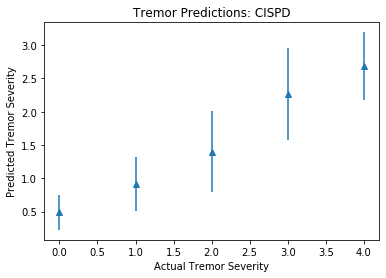

In [146]:
 
plt.errorbar(stats['tremor'], stats['xgb_pred']['mean'], stats['xgb_pred']['std'], linestyle='None', marker='^')
plt.title('Tremor Predictions: CISPD')
plt.xlabel('Actual Tremor Severity')
plt.ylabel('Predicted Tremor Severity')
plt.show()

## TESTING (WILL BE UPDATED WHEN TEST LABELS ARE PUBLISHED)

In [ ]:

#pd.read_csv(f) for f in all_filenames 

mycsvdir = 'testing_data\CIS_testing'

csvfiles = glob.glob(os.path.join(mycsvdir, '*.csv'))

Means=[]
for csvfile in csvfiles:
    df = pd.read_csv(csvfile)
    
    measurement_id = os.path.basename(csvfile)
    measurement_id = measurement_id.replace(".csv","")
    
    df["r"] = np.sqrt(df.X**2+df.Y**2+df.Z**2)
    dr = np.sqrt(np.diff(df.X)**2+np.diff(df.Y)**2+np.diff(df.Z)**2)
    mean_r = np.median(df.r)
    std_r = np.std(df.r)
    min_r = np.min(df.r)
    max_r = np.max(df.r)
    skew_r = skew(df.r)
    kurtosis_r = kurtosis(df.r)
    
    mean_dr = np.median(dr)
    std_dr = np.std(dr)
    min_dr = np.min(dr)
    max_dr = np.max(dr)
    skew_dr = skew(dr)
    kurtosis_dr = kurtosis(dr)
    
    """Extract frequency bands in Hz"""
    FreqBandx = sig.lfilter(Filter[0],Filter[1],df["X"]);
    FreqBandy = sig.lfilter(Filter[0],Filter[1],df["Y"]);
    FreqBandz = sig.lfilter(Filter[0],Filter[1],df["Z"]);
    
    """Find the power in each frequency Band"""
    PowerFreqBandx = np.abs(FreqBandx)**2;
    PowerFreqBandy = np.abs(FreqBandy)**2;
    PowerFreqBandz = np.abs(FreqBandz)**2;
    
    """Sum the power in each frequency band"""
    SumPowerFreqBandx = np.sum(PowerFreqBandx);
    SumPowerFreqBandy = np.sum(PowerFreqBandy);
    SumPowerFreqBandz = np.sum(PowerFreqBandz);
    
    """Sum the total signal power"""
    Powerx = np.sum(df["X"]**2);
    Powery = np.sum(df["Y"]**2);
    Powerz = np.sum(df["Z"]**2);
    
    """Find the percentage of power in frequencies of interest"""
    FreqPower = np.sqrt((SumPowerFreqBandx+SumPowerFreqBandy+SumPowerFreqBandz)/(Powerx+Powery+Powerz));
    
    Means.append([measurement_id, mean_r, std_r, min_r, max_r, skew_r, kurtosis_r, 
                     mean_dr,std_dr, min_dr, max_dr, skew_dr, kurtosis_dr,FreqPower])
    
    """
    #Relevant features 
    measurement_id = csvfile[25:-4]
    
    #average
    mean_x = np.mean(df['X'])
    mean_y = np.mean(df['Y'])
    mean_z = np.mean(df['Z'])  
    
    #standard deviation
    std_x = np.std(df['X'])
    std_y = np.std(df['Y'])
    std_z = np.std(df['Z'])
    
    #minimum
    min_x = np.min(df['X'])
    min_y = np.min(df['Y'])
    min_z = np.min(df['Z'])
    
    #maximum
    max_x = np.max(df['X'])
    max_y = np.max(df['Y'])
    max_z = np.max(df['Z'])
    
    #skewness
    skew_x = skew(df['X'])
    skew_y = skew(df['Y'])
    skew_z = skew(df['Z'])
    
    #kurtosis
    kurtosis_x=kurtosis(df['X'])
    kurtosis_y=kurtosis(df['Y'])
    kurtosis_z=kurtosis(df['Z'])
    
    
    #median
    
    Means.append([measurement_id, 
                  mean_x, std_x, min_x, max_x, skew_x,kurtosis_x,
                  mean_y, std_y, min_y, max_y, skew_y,kurtosis_y,
                  mean_z, std_z, min_z, max_z, skew_z, kurtosis_z])
    

test_data = pd.DataFrame(Means, columns = ['measurement_id',
                                       'mean_x', 'std_x', 'min_x', 'max_x','skew_x', 'kurtosis_x',
                                       'mean_y', 'std_y', 'min_y', 'max_y', 'skew_y', 'kurtosis_y',
                                       'mean_z', 'std_z', 'min_z', 'max_z', 'skew_z', 'kurtosis_z']) 
   
"""

In [ ]:
test_data = pd.DataFrame(Means, columns=["measurement_id", "mean_r", "std_r", 
                                              "min_r", "max_r", "skew_r", "kurtosis_r",
                                              "mean_dr", "std_dr", "min_dr", "max_dr", 
                                              "skew_dr", "kurtosis_dr","FreqPower"])
   
test_data.head()

In [ ]:
test_subjects = pd.read_csv('testing_data\cis-pd.CIS-PD_Test_Data_IDs.csv')
test_subjects.subject_id = test_subjects.subject_id.astype(str)
test_subjects.head()

In [ ]:
test_subjects.subject_id.unique()==labels.subject_id.unique()

In [ ]:
df_test=pd.merge(test_data, test_subjects, on="measurement_id")
df_test.head()

In [ ]:
train = df_tremors.drop(['tremor', 'tremor_null'], axis=1)
train.head()

In [ ]:
cols_train = train.columns[:-1]
scaler = scaler.fit(train[cols_train])
train[cols_train] = scaler.transform(train[cols_train])
train.head()

In [ ]:
cols_test = df_test.columns[1:-1]
df_test[cols_test] = scaler.transform(df_test[cols_test])
df_test.head()


In [ ]:
df_test.subject_id.unique()

In [ ]:
df_tremors.subject_id.unique()

In [ ]:
test= pd.get_dummies(df_test[df_test.columns[1:]])
test = test.drop(['subject_id_1044', 'subject_id_1051', 'subject_id_1039'], axis=1)
test.head()

In [ ]:
train = pd.get_dummies(train)
train.head()

In [ ]:
dtrain=xgb.DMatrix(data=train, label=df_tremors.tremor)
dtest = xgb.DMatrix(data=test)

In [ ]:
param = {'objective': 'multi:softmax',
         'num_class': 5,
         'max_depth' : 5,
         'learning_rate': 0.4
        }
bst = xgb.train(param, dtrain)
xgb_pred = bst.predict(dtest)

In [ ]:
#make predictions on test class
knn = KNeighborsClassifier(n_neighbors=k)
df_X = pd.concat([X_t_train,X_t_test])
df_y = pd.concat([y_t_train, y_t_test])
knn.fit(df_X, df_y)
predictions= knn.predict(df_test[df_test.columns[1:]])

In [ ]:
#df_test['prediction']=predictions

In [ ]:
df_test.head()

In [ ]:
classifier.fit(df_X, df_y)

In [ ]:
predictions_forest = classifier.predict(df_test[df_test.columns[1:]])

In [ ]:
predictions_forest.shape

In [ ]:
test_subjects.shape

In [ ]:
df_test["prediction"]=xgb_pred

In [ ]:
df_test.head()

In [ ]:
df_test[['measurement_id', 'prediction']].to_csv("cis_pd_tremor_predictions.csv", index=False)